In [3]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import os
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

# 1 Importation des données et nettoyage préliminaire 

## a) Tool box 

In [4]:
# Retourne les données chargées sous le format pandas.DataFrame
def LoadData(monthyear ,name_ccy):
    files = []
    FILES =os.listdir(os.getcwd()+"/mars19/")
    FILES.remove('.DS_Store')
    for x in FILES:
        final_path = monthyear+"/"+x+"/binance_mkdata_"+name_ccy+"_"+x[4:]+".h5"
        df = pd.read_hdf(final_path)
        files.append(df)
    data = pd.concat(files)
    data.sort_index(inplace = True)
    data["tradetime"]=[datetime.timestamp(x) for x in data.index.tolist()] #ajout colone timestamp
    data["achat vente"]=IsBidAsk(data.isbuyermm)
    return data

# Retourne une liste indiquant 'achat' si x vaut 0, vendeur sinon
def IsBidAsk(df):
    newdf = df
    newdf[newdf==1] = "vendeur"
    newdf[newdf==0] = "acheteur"
    return newdf

#Retourne un dataframe avec de nouvelles données extraites des données chargées et regroupées par période de temps   
def WindowData(dataframe, timesample ):
    new_data = pd.DataFrame(columns=["Open","Close","Price variation","Volume variation", "Buy orders", "Sell order", "Buy volume", "Sell volume", "Rapport volume"])
    tradetime = dataframe.tradetime[0]
    i = 0
    maxtradetime = dataframe['tradetime'].iloc[-1]
    while tradetime+timesample < maxtradetime:
        window_data = dataframe[dataframe["tradetime"] - tradetime < timesample]
        window_data = window_data[window_data["tradetime"]-tradetime >=0]
        #(window_data["price"].iloc[-1]-window_data["price"].iloc[0])*100/(window_data["price"].iloc[0]),
        new_data.loc[i] = [window_data['price'].iloc[0],window_data["price"].iloc[-1],
                           np.log(window_data["price"].iloc[-1])-np.log(window_data["price"].iloc[0]),
                          (window_data["qty"].iloc[-1]-window_data["qty"].iloc[0])*100/(window_data["qty"].iloc[0]),
                          1+len(window_data[window_data["achat vente"]=='acheteur']),
                          1+len(window_data)-len(window_data[window_data["achat vente"]=='acheteur']), 
                          1+window_data[window_data["achat vente"]=='acheteur']["qty"].sum(),
                          1+window_data[window_data["achat vente"]=='vendeur']["qty"].sum(),
                          window_data[window_data["achat vente"]=='acheteur']["qty"].sum()/(1+window_data[window_data["achat vente"]=='vendeur']["qty"].sum())
                            ]
        i = i+1
        #douille : quand il y a que 1 ordre passé durant un timesample, il faut passer au timstamp d'apres ... sinon boucle infinie
        tradetime = dataframe.loc[dataframe["tradetime"] > window_data['tradetime'].iloc[-1]]["tradetime"].iloc[0]
    variation_qty_achat = new_data["Buy volume"].tolist()
    variation_qty_vente = new_data["Sell volume"].tolist()
    for i in range(1,len(variation_qty_achat)):
        variation_qty_achat[i]=(new_data["Buy volume"].iloc[i]-new_data["Buy volume"].iloc[i-1])*100/(new_data["Buy volume"].iloc[i-1])
        variation_qty_vente[i]=(new_data["Sell volume"].iloc[i]-new_data["Sell volume"].iloc[i-1])*100/(new_data["Sell volume"].iloc[i-1])
    new_data["Buy volume variation"]=variation_qty_achat
    new_data["Sell volume variation"]=variation_qty_vente
    #décalage des variations de prix pour devenir des cibles
    variation_prix_decal = new_data["Price variation"].drop([0])
    variation_prix_decal.loc[len(variation_prix_decal)+1]=variation_prix_decal.iloc[-1]
    variation_prix_decal= variation_prix_decal.tolist()
    new_data["Future price variation"]=variation_prix_decal
    new_data = new_data.drop([0,len(new_data)-1])
    #normalisation des données 
    for x in new_data.columns[3:-1]:
        new_data[x]=preprocessing.scale(new_data[x])
    return new_data

#Retourne le pourcentage de nombres ayant 2à2 le même signe dans 2 listes 
def SigneCompare(liste1, liste2):
    good_prediction_signe = 0
    for i in range(len(liste1)-1):
        if liste1[i]*liste2[i]>0:
            good_prediction_signe +=1
    return good_prediction_signe*100/len(liste1)

# Retourne une série décalée de la série entrée
def lag(series,n):
    return series[0:n]+series[:-n]

#Retourne un Dataframe avec de nouvelles colones décallé des colones initiales
def DataLaged(df, columns_to_lag, n_lag, target):
    final_df = df[columns_to_lag]
    for i in range(1,n_lag+1):
        for col in columns_to_lag:
            final_df[col+" n-"+str(i)]=lag(list(df[col]),i)
    final_df[target]=df[target]
    final_df = final_df[n_lag:]
    final_df.reset_index(drop = True, inplace = True)
    return final_df

#Retourne la liste d'erreures des prédictions pour un modele de regressin linéaire en fonction du décallage des données
def ModelSelectionLag(resample_data, N):
    liste_error = []
    liste_suuces_signe_prediction = []
    for i in range (1,N):
        laged_data_selection = DataLaged(resample_data,["Price variation", "Buy orders", "Sell order"],i,"Future price variation")
        #Set model FOR LAG
        reg = LinearRegression()
        #Set data
        X, y = laged_data_selection.iloc[:,:-1],laged_data_selection.iloc[:,-1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = False, stratify = None)
        #Train
        reg.fit(X_train, y_train)
        prediction = reg.predict(X_test)
        liste_error.append(NormeL1(y_test, prediction))
        liste_suuces_signe_prediction.append(SigneCompare(list(prediction),list(y_test)))
    return (liste_error,liste_suuces_signe_prediction)

#Retourne la somme des erreure
def NormeL0(liste1, liste2):
    return sum([np.abs(x-y) for x,y in zip(liste1,liste2)])

#Retourne la norme L1
def NormeL1(liste1, liste2):
    return np.mean([np.abs(x-y) for x,y in zip(liste1,liste2)])

#Retourne la norme L2
def NormeL2(liste1, liste2):
    return np.sqrt(np.mean([pow(x-y,2) for x,y in zip(liste1,liste2)]))

#Retourne les prédiction comme moyenne des N dernieres observations
def MobileMeanPredict(liste, N):
    prediction = []
    for i in range(N,len(liste)):
        prediction.append(np.mean(liste[i-N:i]))
    return prediction 

#Retourne la liste des erreurs du modèle moyenne mobile en fonction de N
def SelectBestN(prices,target,liste_N):
    return [NormeL2(MobileMeanPredict(prices, i), target[i:]) for i in liste_N]

def OptimizeXGB(model, X_, y_):
    parameters = [{"colsample_bytree":[n/10 for n in range(1,11)]},
                  {"subsample":[n/10 for n in range(1,11)]},
                  {"learning_rate":[n/20 for n in range(1, 21)]},
                  {"max_depth":range(5,15)},
                  {"min_child_weight":range(5,15)},
                  {"alpha":[n/20 for n in range(1, 41)]},
                  {"n_estimators":range(10,50)}]
    best_param = []
    for p in parameters:
        clf = GridSearchCV(model, p)
        clf.fit(X,y)
        best_param.append(clf.best_params_)
    return best_param

def SimpleStrategie(df, index, prediction, buy_limit = 0):
    rendement = []
    for i in range(len(index)):
        if prediction[i]>=buy_limit:
            try:
                rendement.append(df["Close"].loc[index[i]+1]-df["Open"].loc[index[i]+1])
            except:
                pass
    return rendement

def AnalysePnL(rendement):
    return [sum(rendement), np.mean(rendement), np.std(rendement)**2,max(rendement), min(rendement), len([x for x in rendement if x>=0])*100/len(rendement)]


## Importation des données (paire utilisée ici : BNBUSDT)

In [5]:
data = LoadData("mars19","BNBUSDT")
data.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,isbuyermm,price,qty,tradetime,achat vente
tradetime,,,,,
2019-03-01 00:00:03.016,acheteur,10.2881,562.599976,1.551395e+09,acheteur
2019-03-01 00:00:03.016,vendeur,10.2888,749.200012,1.551395e+09,vendeur
2019-03-01 00:00:07.174,vendeur,10.2891,23.900000,1.551395e+09,vendeur
2019-03-01 00:00:07.400,vendeur,10.2891,5.840000,1.551395e+09,vendeur
2019-03-01 00:00:16.736,acheteur,10.2881,458.559998,1.551395e+09,acheteur


On résample les données avec une période de 5 minutes par exemple.

In [21]:
#peut prenre quelques minutes
resample_data = WindowData(data, 5*60) 
resample_data.head()

,Open,Close,Price variation,Volume variation,Buy orders,Sell order,Buy volume,Sell volume,Rapport volume,Buy volume variation,Sell volume variation,Future price variation
1,10.2938,10.3076,0.001340,-0.089454,-0.907330,-0.613752,-0.690816,-0.612117,-0.680202,-0.597714,-0.600009,-0.000815
2,10.3085,10.3001,-0.000815,-0.098862,-0.490976,-0.577100,0.007736,-0.282155,0.342501,2.977653,0.855623,-0.000262
3,10.3030,10.3003,-0.000262,-0.061578,-0.637924,-0.629460,0.029589,0.047858,-0.247080,-0.235607,0.145266,-0.000845
4,10.2978,10.2891,-0.000845,0.537610,-0.644047,-0.692292,-0.172038,-0.186642,-0.203678,-0.365380,-0.436575,-0.001595
5,10.2900,10.2736,-0.001595,-0.020880,-0.717522,-0.760361,-0.528375,-0.464438,-0.431774,-0.521871,-0.548805,0.000224


# 2 Prédiction

## a) Moyenne mobile 

### Séléction de modèle

In [22]:
# Set data
X, y = resample_data.iloc[:,:-1],resample_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = False, stratify = None)

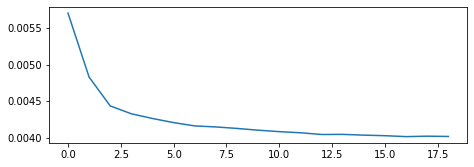

In [23]:
plt.figure(figsize=(7.5,2.5))
plt.plot(SelectBestN(X_train["Price variation"],y_train, range(1,20))) 

On choisi le plus petit N qui minimise l'erreure

No handles with labels found to put in legend.


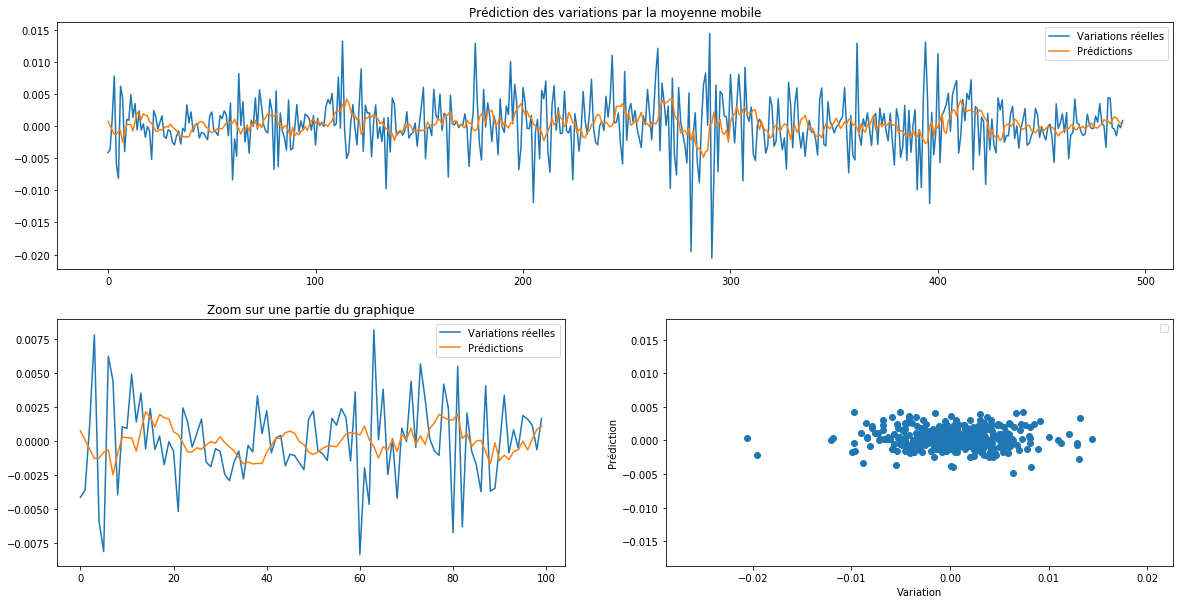

In [41]:
N=7
predictionmm = MobileMeanPredict(X_test["Price variation"], N)
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(list(y_test[N:]), label = "Variations réelles")
plt.plot(predictionmm, label="Prédictions")
plt.title("Prédiction des variations par la moyenne mobile")
plt.legend()
plt.subplot(2,2,3)
plt.plot(list(y_test[N:])[:100], label = "Variations réelles")
plt.plot(predictionmm[:100], label="Prédictions")
plt.title("Zoom sur une partie du graphique")
plt.legend()
plt.subplot(2,2,4)
plt.scatter(y_test[N:], predictionmm)
plt.xlabel('Variation')
plt.ylabel('Prédiction')
plt.legend()

## b) Régression linéaire 

#### Exemple jouet : modèle entrainé sur les donées bruts resamplées toutes les 5 minutes

No handles with labels found to put in legend.


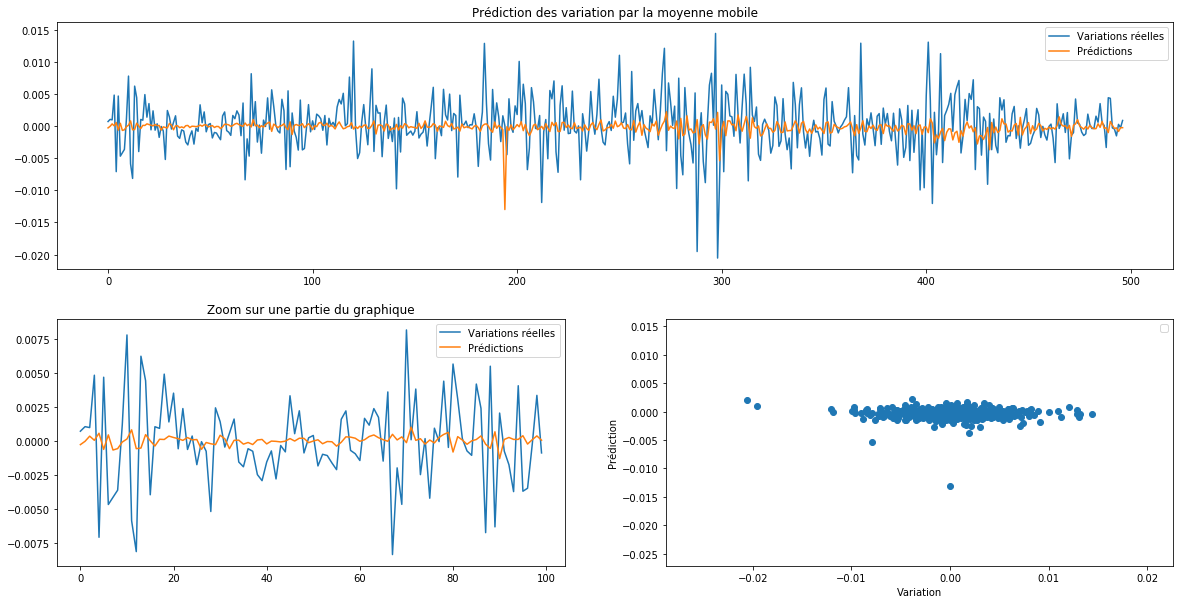

In [40]:
#Set model
reg = LinearRegression()

#Train
reg.fit(X_train, y_train)
prediction = reg.predict(X_test)

#Plot
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(list(y_test), label = "Variations réelles")
plt.plot(list(prediction), label="Prédictions")
plt.title("Prédiction des variation par la moyenne mobile")
plt.legend()
plt.subplot(2,2,3)
plt.plot(list(y_test)[:100], label = "Variations réelles")
plt.plot(list(prediction)[:100], label="Prédictions")
plt.title("Zoom sur une partie du graphique")
plt.legend()
plt.subplot(2,2,4)
plt.scatter(y_test, prediction)
plt.xlabel('Variation')
plt.ylabel('Prédiction')
plt.legend()

#### Données décalées : introduction du lag

A présent, nous allons entraîner notre modèle sur les données lagué (donc avec mémoire) en construisant une suite de série décallées. Nous effectuons d'abord une séléction de modèle avec le meilleur paramètre de lag N, c'est à dire le nombre de décallage à prendre en compte pour obtenir la meilleure estimation. Nous effectuons cette estimation en comaprant les erreures quadratiques des modèles pour chaque N variant entre 1 et 20.

###### Sélection de modèle

In [26]:
models_rates=ModelSelectionLag(resample_data,15)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

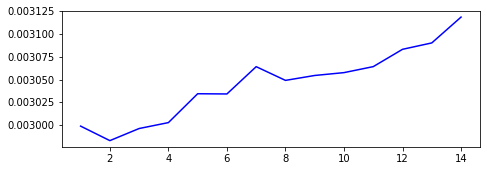

In [27]:
plt.figure(figsize=(7.5,2.5))
plt.plot(range(1,len(models_rates[0])+1), models_rates[0],color = 'blue' )

La séléction de modèle nous indique ici que la meilleure prédiction sachant les passé est la prédcition sachant le prix à t-1 (soit le prix il y a 5 min dans notre cas) car l'erreure de prédiction est minimale pour ce paramètre.

In [38]:
lag_size = 2
laged_data = DataLaged(resample_data.copy(),["Price variation", "Buy orders", "Sell order"],lag_size,"Future price variation")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No handles with labels found to put in legend.


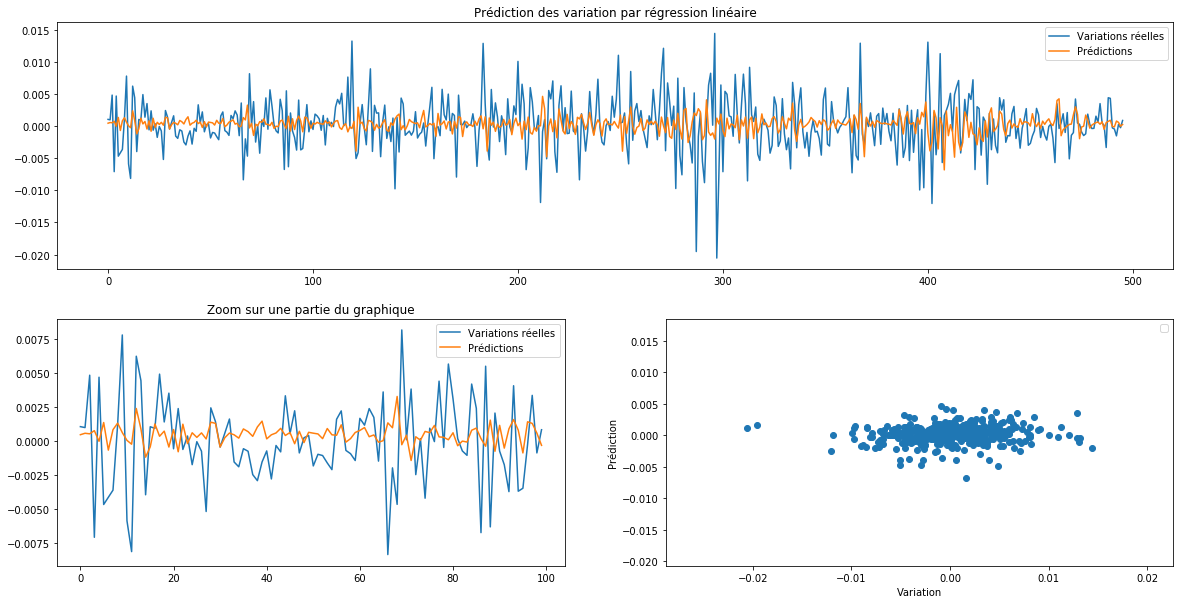

In [39]:
#Set model FOR LAG
reg2 = LinearRegression()
#Set data
X2, y2 = laged_data.iloc[:,:-1],laged_data.iloc[:,-1]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, shuffle = False, stratify = None)
#Train
reg2.fit(X_train2, y_train2)
prediction2 = reg2.predict(X_test2)
#Plot
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(list(y_test2), label = "Variations réelles", linestyle="-")
plt.plot(list(prediction2*2), label="Prédictions")
plt.title("Prédiction des variation par régression linéaire")
plt.legend()
plt.subplot(2,2,3)
plt.plot(list(y_test2)[:100], label = "Variations réelles")
plt.plot(list(prediction2*2)[:100], label="Prédictions")
plt.title("Zoom sur une partie du graphique")
plt.legend()
plt.subplot(2,2,4)
plt.scatter(y_test2, prediction2*2,)
plt.xlabel('Variation')
plt.ylabel('Prédiction')
plt.legend()

C'est un peu mieux mais on constate tout de même le caractère non linéaire du lien qui lie les données cibles aux prédictions. A partir de maintenant, tous les modèles seront entraînés sur les données avec décalage.

# c) Forêts aléatoires

On refait la même chose avec lag

No handles with labels found to put in legend.


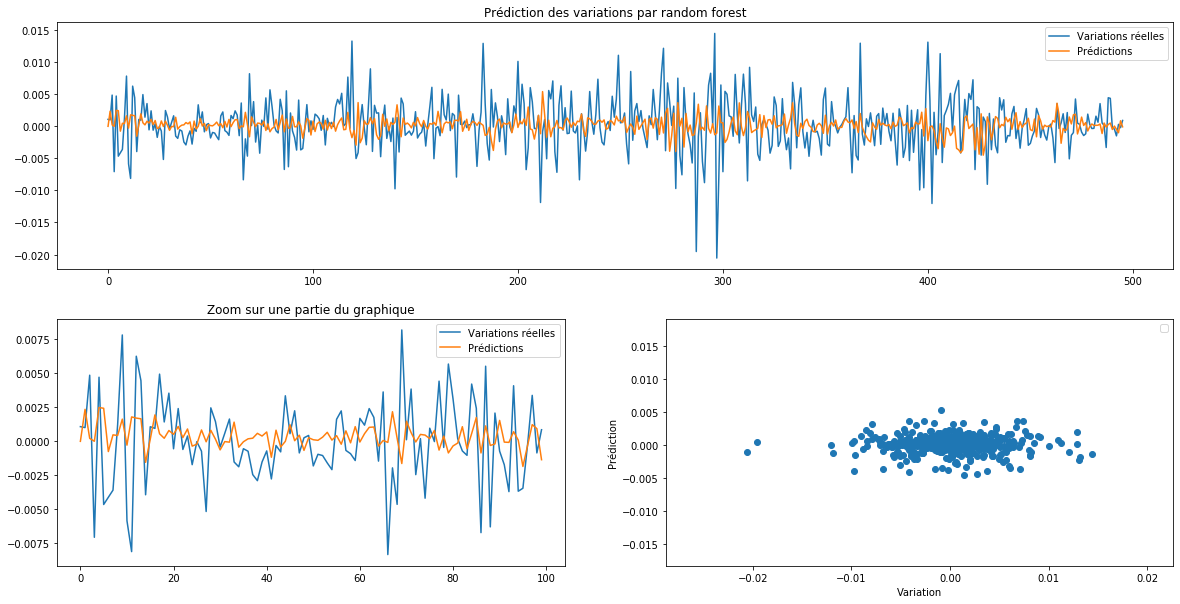

In [37]:
clrf = RandomForestRegressor()
clrf.fit(X_train2, y_train2)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

prediction3 = clrf.predict(X_test2)

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(list(y_test2), label = "Variations réelles", linestyle="-")
plt.plot(list(prediction3), label="Prédictions")
plt.title("Prédiction des variations par random forest")
plt.legend()
plt.subplot(2,2,3)
plt.plot(list(y_test2)[:100], label = "Variations réelles")
plt.plot(list(prediction3)[:100], label="Prédictions")
plt.title("Zoom sur une partie du graphique")
plt.legend()
plt.subplot(2,2,4)
plt.scatter(y_test2, prediction3)
plt.xlabel('Variation')
plt.ylabel('Prédiction')
plt.legend()

C'est un peu mieux

## d) XGBoost

Nous allons finir par la star des algorithmes de machin learning du moment, le XGBoost. Nous suivont la même procédure que les précédents algorithmes à la différence qu'il y a une optimisation des hyperparamètres à effectuer.

In [31]:
#Define model
regxgb = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, subsample = 0.3, learning_rate = 0.9,
                max_depth = 6,min_child_weight=8, alpha=0.001, n_estimators = 14)

#Set data
X1, y1 = laged_data.iloc[:,:-1],laged_data.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X1,label=y1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, shuffle = False, stratify = None)

"""
Attention, un peu long!!
#Optimisation
best_parameters = OptimizeXGB(regxgb, X1_train, y1_train)
print(best_parameters)
"""


'\nAttention, un peu long!!\n#Optimisation\nbest_parameters = OptimizeXGB(regxgb, X1_train, y1_train)\nprint(best_parameters)\n'

No handles with labels found to put in legend.


[00:09:57] WARNING: /private/var/folders/hm/bc6qc0t94gl_8ftplydxn2pm0000gn/T/pip-install-ir4lbdyb/xgboost/xgboost/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


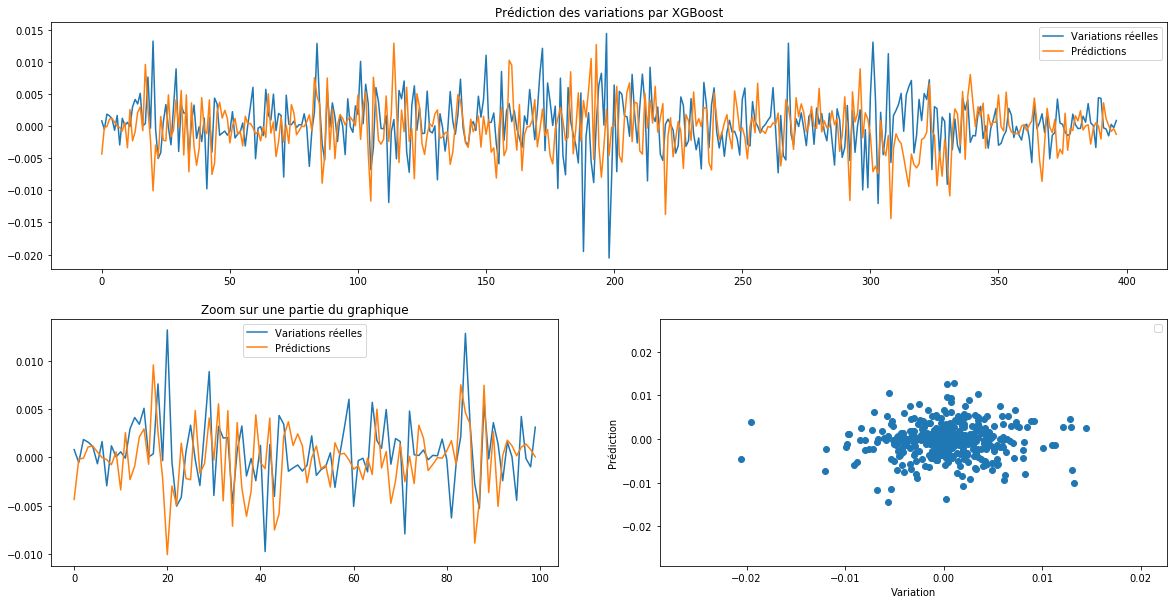

In [36]:
#Define model with bests parameters
regxgb = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, subsample = 1, learning_rate = 0.99,
                max_depth = 7,min_child_weight=12, alpha=0.001, n_estimators = 10)
#Train 
regxgb.fit(X1_train ,y1_train)
#Prediction
predictionxgb =  regxgb.predict(X1_test)
#Plot
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(list(y1_test), label = "Variations réelles", linestyle="-")
plt.plot(list(predictionxgb), label="Prédictions")
plt.title("Prédiction des variations par XGBoost")
plt.legend()
plt.subplot(2,2,3)
plt.plot(list(y1_test)[:100], label = "Variations réelles")
plt.plot(list(predictionxgb)[:100], label="Prédictions")
plt.title("Zoom sur une partie du graphique")
plt.legend()
plt.subplot(2,2,4)
plt.scatter(y1_test, predictionxgb)
plt.xlabel('Variation')
plt.ylabel('Prédiction')
plt.legend()

# 3 Quelques comparaisons 


Tout d'abord, nous analysons rapidement l'erreur RMSE classique de chaque modèle et ensuite nous analysons le pourcentage de succès de chaque modèle à prédire le bon sens de variation

In [33]:
results = pd.DataFrame(index=['Moving average','Linear regresion without lag', 'Linear regresion with lag', 'Random forest','XGBoost'] ,columns = ['RMSE', "% succes signe predicted"])
#Linear regresion
results["% succes signe predicted"]["Moving average"] = SigneCompare(predictionmm, list(y_test))
results["RMSE"]["Moving average"] = np.sqrt(mean_squared_error(y_test[N:], predictionmm))
#Linear regresion without lag
results["% succes signe predicted"]["Linear regresion without lag"] = SigneCompare(list(prediction), list(y_test))
results["RMSE"]["Linear regresion without lag"] = np.sqrt(mean_squared_error(y_test, prediction))
#Linear regresion with lag
results["% succes signe predicted"]["Linear regresion with lag"] = SigneCompare(list(prediction2), list(y_test2))
results["RMSE"]["Linear regresion with lag"] = np.sqrt(mean_squared_error(y_test2, prediction2))
#Random forest
results["% succes signe predicted"]["Random forest"] = SigneCompare(list(prediction3),list(y_test2))
results["RMSE"]["Random forest"] = np.sqrt(mean_squared_error(y_test2, prediction3))
#XGBoost
results["% succes signe predicted"]["XGBoost"] = SigneCompare(list(predictionxgb),list(y1_test))
results["RMSE"]["XGBoost"] = np.sqrt(mean_squared_error(y1_test, predictionxgb))

results

,RMSE,% succes signe predicted
Moving average,0.00435649,60.4082
Linear regresion without lag,0.00431588,49.497
Linear regresion with lag,0.00416758,53.4274
Random forest,0.00438374,46.9758
XGBoost,0.00576066,48.8665


# 4 Un peu de trading


Pour commencer, nous allons considérer un marché parfait, sans friction, sans coût de transaction où les ordres sont passés instantanément . Nous allons alors commencer par une la plus simple stratégie qui soit: acheter une unité si notre modèle prédit une hausse puis liquider la position à l'issue de la période de temps où la prédiction est valable.

###### P&L pour chaque modèle :

In [34]:
rendementMM = SimpleStrategie(resample_data, y_test[N:].index, predictionmm, buy_limit = 0)
rendement = SimpleStrategie(resample_data, y_test.index, prediction, buy_limit = 0)
rendement2 = SimpleStrategie(resample_data, y_test2.index, prediction2, buy_limit = 0)
rendement3 = SimpleStrategie(resample_data, y_test2.index, prediction3, buy_limit = 0)
rendementxgb = SimpleStrategie(resample_data, y1_test.index, predictionxgb, buy_limit = 0)

In [35]:
PnL = pd.DataFrame(index=['Moving average','Linear regresion without lag', 'Linear regresion with lag', 'Random forest','XGBoost'] ,columns = ['PnL','Mean','Variance',"Max win", "Max loss", "Positives transactions"])
#Linear regresion
PnL.loc["Moving average"] = AnalysePnL(rendementMM)
#Linear regresion without lag
PnL.loc["Linear regresion without lag"] = AnalysePnL(rendement)
#Linear regresion with lag
PnL.loc["Linear regresion with lag"] = AnalysePnL(rendement2)
#Random forest
PnL.loc["Random forest"] = AnalysePnL(rendement3)
#XGBoost
PnL.loc["XGBoost"] = AnalysePnL(rendementxgb)

PnL

,PnL,Mean,Variance,Max win,Max loss,Positives transactions
Moving average,0.9842,0.0035276,0.00386572,0.2174,-0.3091,53.0466
Linear regresion without lag,0.5258,0.0025401,0.00396671,0.1842,-0.3091,52.657
Linear regresion with lag,0.4454,0.00137469,0.00365732,0.1935,-0.3091,52.1605
Random forest,0.1386,0.000488028,0.00312293,0.1842,-0.2956,51.7606
XGBoost,-0.1739,-0.000966111,0.0039567,0.1935,-0.2956,51.1111
